In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [38]:
# Set directory
# "C:\Users\AHema\OneDrive - CGIAR\Desktop\Poverty Mapping\Small area estimation\Burkina Faso\Application of Fay-Herriot Model for Burkina Faso\00.Data\data_admin2.csv"
path = 'C:/Users/AHema/OneDrive - CGIAR/Desktop/Poverty Mapping/Small area estimation/Burkina Faso/Application of Fay-Herriot Model for Burkina Faso/00.Data/'

# Import data
data = pd.read_csv(path + 'data_admin2.csv', header = 0)
sample = data.dropna() 
y = sample['direct']
X = sample.drop(columns = ['adm2_pcode', 'direct', 'true'])  
data = sample.drop(columns = ['adm2_pcode', 'direct', 'true'])  

In [39]:
X.head()

,hage,hgender1,mstat1,nation2,toit1,eauboi_ss1,eva_toi1,cuisin1,hmstat1,hreligion1,...,geo_brba,geo_nbai,geo_vari,geo_savi,geo_osavi,geo_evi,geo_ndvi,geo_sr,geo_arvi,geo_ui
0,0.520430,0.653777,-1.102867,-1.302262,-1.034612,-0.717939,-0.818556,-1.070433,0.630005,-0.300101,...,0.719427,-0.533751,-0.082865,0.138285,0.120597,0.298890,0.141071,1.330860,0.263659,-0.074136
1,-0.419322,0.230302,-0.034757,0.207259,-1.176101,-0.589367,-2.533937,-0.070255,0.234498,-0.071287,...,0.744203,-0.552713,-0.056053,0.150986,0.133281,0.372096,0.157281,1.374712,0.249889,-0.109804
2,-0.797929,1.203840,0.773177,-0.771416,-0.813012,2.064349,0.849107,0.658789,-0.772563,0.884050,...,0.707699,-0.555079,-0.064364,0.160395,0.141618,0.367193,0.167154,1.402104,0.272363,-0.087204
3,0.082242,0.579727,1.195810,0.785839,0.336326,2.187543,0.390603,0.862152,-0.772563,0.825752,...,0.733634,-0.518769,-0.071453,0.146751,0.127988,0.336228,0.149754,1.353635,0.259805,-0.075177
4,-1.047475,0.366074,0.112064,-2.946729,-0.773798,0.326899,-3.789216,-1.122897,-0.332459,-0.002220,...,0.717915,-0.553546,-0.062317,0.156780,0.138144,0.373307,0.162808,1.390073,0.261224,-0.096914


In [40]:
y.head()

0    0.039664
1    0.332934
2    0.795501
3    0.597162
4    0.215113
Name: direct, dtype: float64

1. Data Preparation

In [41]:

# Assuming X is your features and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2. XGBoost Model Initialization

In [42]:
import xgboost as xgb

# Initialize the XGBRegressor
model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)


3. Hyperparameter Tuning

In [43]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and refit the model
best_params = grid_search.best_params_
model = grid_search.best_estimator_


4. Training and Evaluation

In [44]:
# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
n = len(y_test)  # number of observations
k = X_test.shape[1]  # number of independent variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(f"Adjusted R-squared: {adjusted_r2}")

Mean Squared Error: 0.03447550905708348
R-squared: -0.7359637223043307
Adjusted R-squared: 1.8679818611521655


In [36]:
from sklearn.model_selection import GridSearchCV

# Example grid search for parameter tuning
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
print(f'Improved R-squared: {r2_best:.4f}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50}
Improved R-squared: -0.3659


R2 measures how well the model explains the variance in the dependent variable.

Adjusted 𝑅2 penalizes for adding variables that do not improve the model significantly.

5. Regularization and Validation

In [33]:
# Example of using early stopping
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=eval_set, verbose=True)


[0]	validation_0-rmse:0.15061
[1]	validation_0-rmse:0.15288
[2]	validation_0-rmse:0.15929
[3]	validation_0-rmse:0.16476
[4]	validation_0-rmse:0.16118
[5]	validation_0-rmse:0.15599
[6]	validation_0-rmse:0.15736
[7]	validation_0-rmse:0.16158
[8]	validation_0-rmse:0.16665
[9]	validation_0-rmse:0.16336
[10]	validation_0-rmse:0.16755


C:\Users\AHema\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\AHema\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
# Generate poverty estimates
X_all = sample.drop(columns = ['adm2_pcode', 'direct', 'true']) 
y_pred = model.predict(X_all)
y_pred = pd.DataFrame({'adm2_pcode': sample['adm2_pcode'], 'predict': y_pred, 'direct': sample['direct']})
y_pred

,adm2_pcode,predict,direct
0,BF1300,0.374399,0.039664
1,BF4601,0.408763,0.332934
2,BF4602,0.463393,0.795501
3,BF4603,0.463393,0.597162
4,BF4604,0.404717,0.215113
5,BF4605,0.404717,0.297197
6,BF4606,0.463393,0.536172
7,BF4701,0.405038,0.198440
8,BF4702,0.405038,0.374854
9,BF4801,0.408763,0.257948


6. Feature Importance

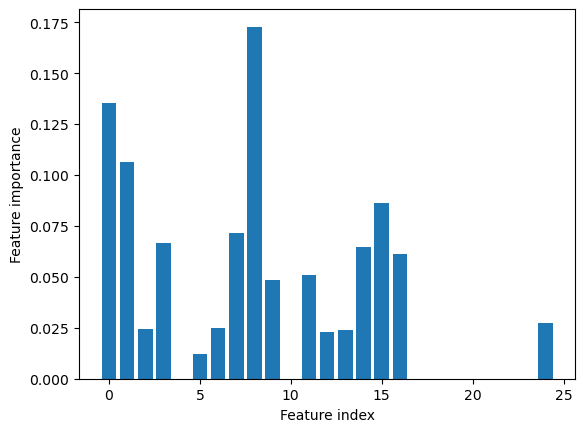

In [9]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()


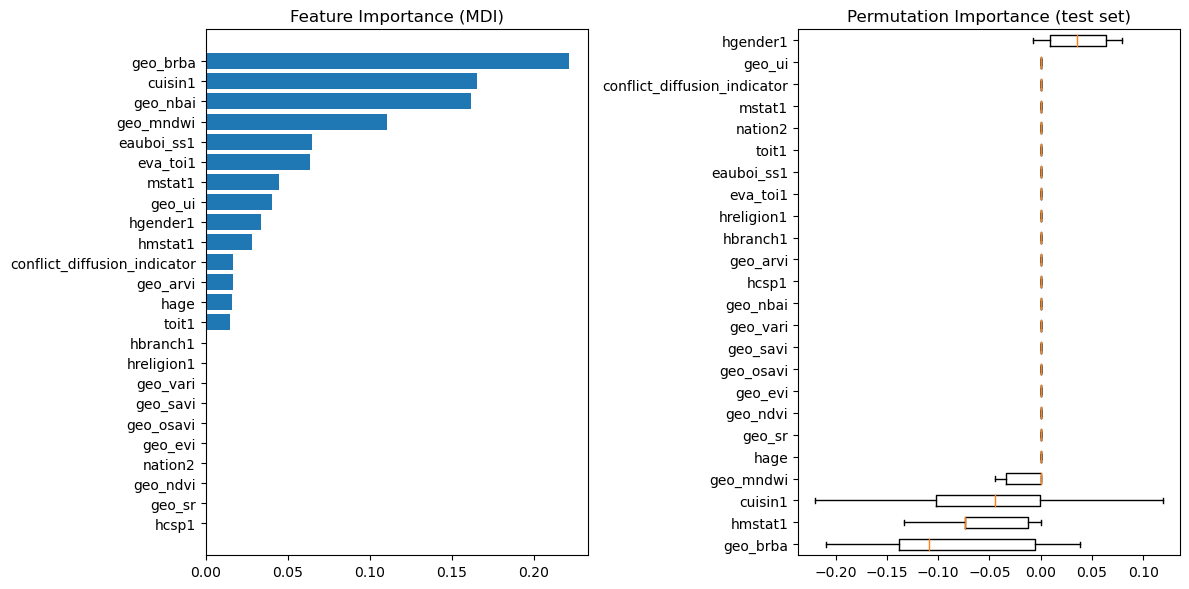

In [35]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(data.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Final Notes
Ensemble Methods: Consider ensemble methods like bagging or boosting (e.g., using the Booster class in XGBoost) to further stabilize predictions and reduce variance.
Cross-validation: Use cross-validation techniques to ensure the model's robustness and generalization capability, especially with a small dataset.
By following these steps, you can effectively apply XGBoost regression on a small dataset in Python while minimizing overfitting and maximizing predictive performance. Adjustments may be needed based on specific characteristics of your dataset and problem domain.